In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from scripts.models import CustomGNN
from scripts.environment import Environment

In [ ]:
# make toy example

w1_np = np.array([[0.1, 0.2, 0.3], [0.4, 0.7, 0.6], ]).T
w2_np = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], ]).T


w1 = torch.tensor(w1_np, dtype=torch.float32)
w2 = torch.tensor(w2_np, dtype=torch.float32)

print("input")
print(w1.shape)
print(w1)
print(w2)

rows = w1[None, :, :] - w2[:, None, :]
print("rows")
print(rows.shape)

ni1 = 1
ni2 = 1

print(w1[ni1,:])
print(w2[ni2,:])
print(rows[ni1,ni2])

a_b_diffs = torch.linalg.norm(rows, dim=2)
print("after magnitude")
print(a_b_diffs.shape)
print(a_b_diffs)
print("diff")
print(a_b_diffs[ni1, ni2])

a_norms = torch.linalg.norm(w1, dim=0)
b_norms = torch.linalg.norm(w2, dim=0)
layers = torch.prod(a_b_diffs , dim=1) #/ (a_norms[:, None] + b_norms[None, :])

print("after prod")
print(layers.shape)

sums = torch.sum(layers)

print(sums.item())

input
torch.Size([3, 2])
tensor([[0.1000, 0.4000],
        [0.2000, 0.7000],
        [0.3000, 0.6000]])
tensor([[0.1000, 0.4000],
        [0.2000, 0.5000],
        [0.3000, 0.6000]])
rows
torch.Size([3, 3, 2])
tensor([0.2000, 0.7000])
tensor([0.2000, 0.5000])
tensor([0.0000, 0.2000])
after magnitude
torch.Size([3, 3])
tensor([[0.0000, 0.3162, 0.2828],
        [0.1414, 0.2000, 0.1414],
        [0.2828, 0.1414, 0.0000]])
diff
tensor(0.2000)
after prod
torch.Size([3])
0.004000000189989805


In [2]:
all_positions = []

for i in range(10):
    all_positions.append(np.load(f"positions/random_{i}_positions.npy"))

In [3]:

models = []
for i in range(1,9):
    model = CustomGNN(3, [8], 2, aggregation="mean", biases = True)
    model.load_state_dict(torch.load(f"models/model{i}.pth"))
    model.eval()
    models.append(model)

In [27]:
positions = all_positions[0]

X = torch.zeros(positions.shape[0], 2)


edges, edge_weights, border =  Environment.get_edges(positions)

innerouts = []
for model in models:
    minnerouts = []
    for i in range(int(1000/5)):
        XX = torch.cat((X, border.unsqueeze(1)), dim = 1)

        out, innerout = model.forward_verbose(XX, edges, edge_weights)
        minnerouts.append(innerout.detach().numpy())
        X = out
    innerouts.append(minnerouts)

innerouts = np.array(innerouts)
innerouts.shape

(1000, 8) (1000, 8)


(8, 200, 1000, 8)

(1000, 8)
(1000, 8)


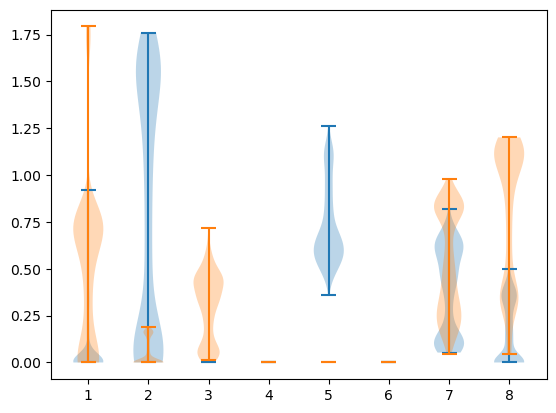

In [55]:
for m in [0,1]:
    xy = innerouts[m, -1,:,:]
    plt.violinplot(xy)
    print(xy.shape)

plt.show()


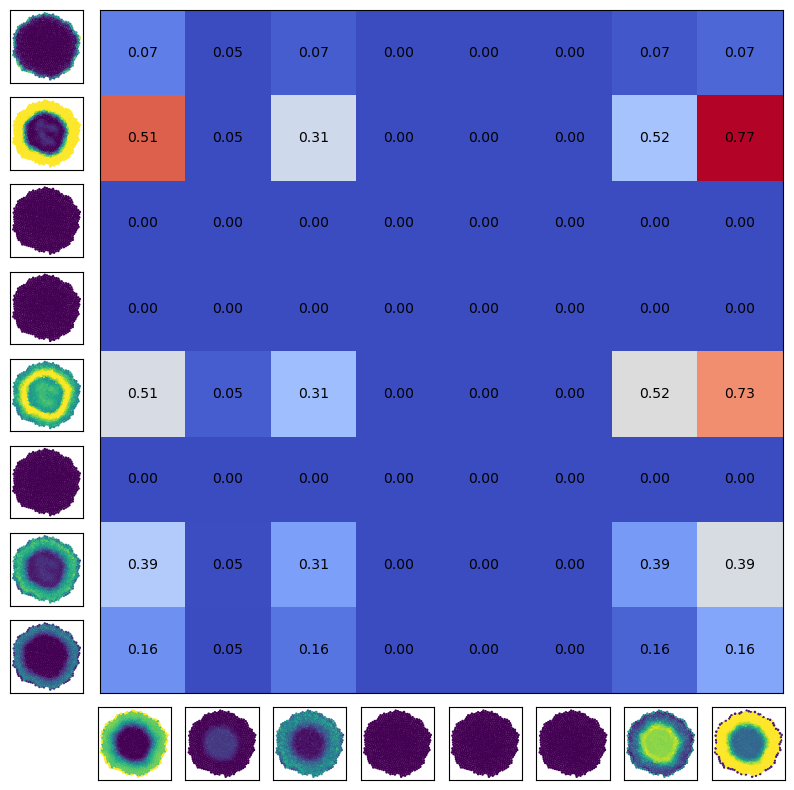

In [208]:
# make an 9x9 grid of axes
fig = plt.figure(figsize=(10,10))  
spec = fig.add_gridspec(9, 9)

for i in range(8):
    for m in [0,1]:
        xy = innerouts[m, -1,:,:]

        xx = i if m == 0 else 8
        yy = 0 if m == 0 else i+1
        ax = fig.add_subplot(spec[xx,yy])
        ax.scatter(positions[:,0], positions[:,1], c = xy[:,i], vmin = 0, vmax = 1., s = 0.7)
        ax.set_xticks([])
        ax.set_yticks([])
        # axs[i,m].set_title(f"Model {m} HL {i}")


d = innerouts[:2, -1,:,:]
np.moveaxis(d, 2, 1).shape
# shape (2, 8, 1000)
# make correlation matrix

correlations = np.zeros((8,8))
mags = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        corr = np.dot(d[0,:,i], d[1,:,j])
        correlations[i,j] = corr#i*10+j
        mags[i,j] = min(np.mean(np.abs(d[0,:,i])), np.mean(np.abs(d[1,:,j])))


upper = np.triu(correlations, k=0)
lower = np.tril(correlations, k=-1)

inner_ax = fig.add_subplot(spec[:-1,1:],) 

inner_ax.imshow(correlations, cmap = "coolwarm")

# plot the mags on the imshow
for i in range(8):
    for j in range(8):
        inner_ax.text(j, i, f"{mags[i,j]:.2f}", ha="center", va="center", color="black")


# plt.colorbar()  
inner_ax.set_xticks([])
inner_ax.set_yticks([])

# fig.tight_layout()

plt.show()

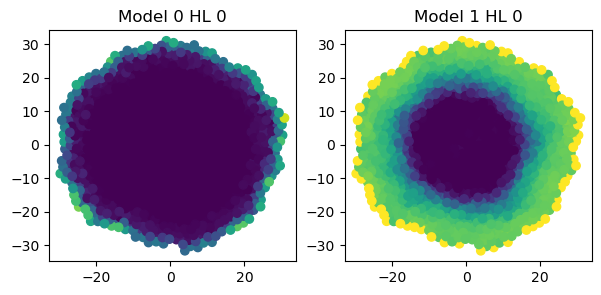

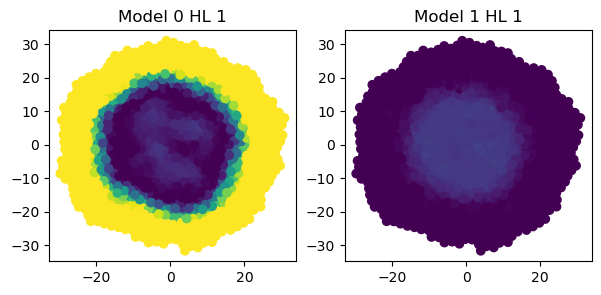

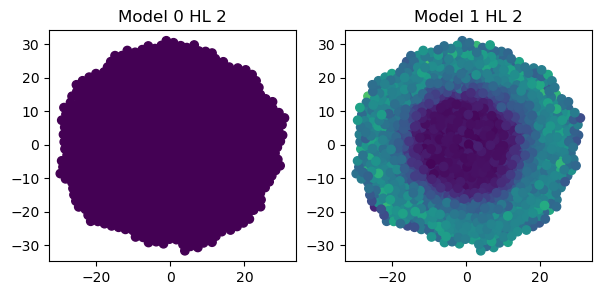

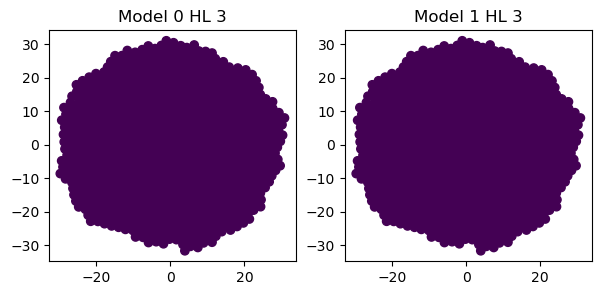

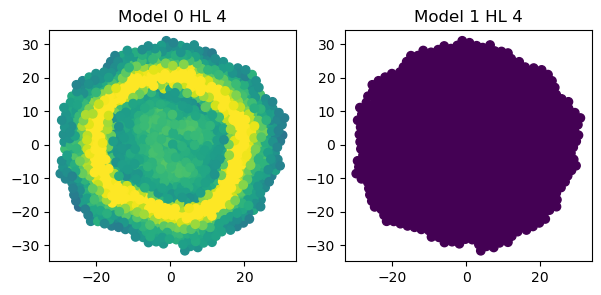

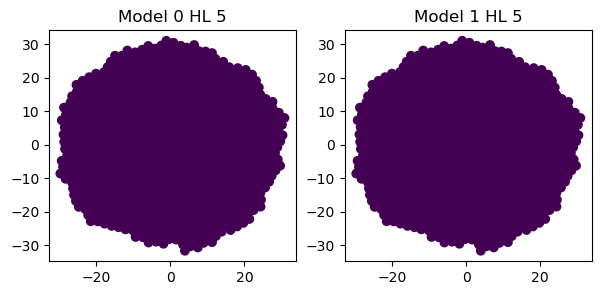

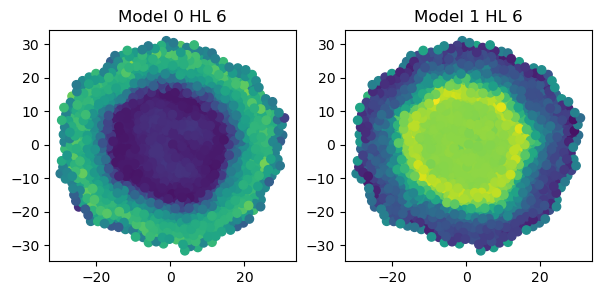

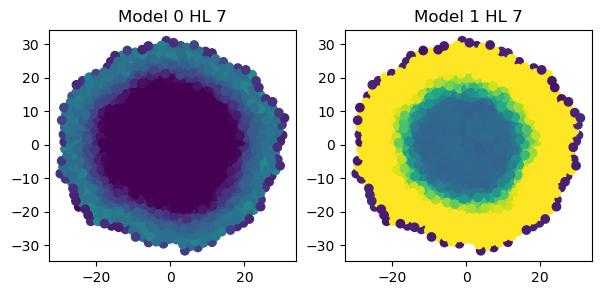

ModuleNotFoundError: No module named 'umap'